In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt  
import numpy as np
%pylab inline
import matplotlib as plt
import urllib
from scipy.stats import pearsonr
import gc

Populating the interactive namespace from numpy and matplotlib


import numpy as np
%pylab inline
import matplotlib as plt
import seaborn as sns
import pandas as pd

In [33]:
#print(gc.get_threshold())
gc.collect()

252

# load DB data

In [34]:
#!wget 'http://141.26.208.111/sessions_alldata_notools_2305_t.csv'
#!wget 'http://141.26.208.111/sessions_alldata_tools_2305_t.csv'
#!wget 'http://141.26.208.111/pages_filtered_2105.csv'
#!wget 'http://141.26.208.111/itempages_2305.csv'
#!wget 'http://141.26.208.111/contributors_filtered_2105.csv'

In [35]:
# INFO (provenance of sessions):
# the sessions where generated following the thresholds defined in: http://143.167.102.51:8888/notebooks/threshold-new_fribourg.ipynb


# INFO (other available data) :
# the data files containing the edit comments and other ignored features, BUT NOT THE SESSIONS, are here: 
# data_notools = pd.read_csv('revisions2notools_0604.csv',sep="\t", usecols=[0,2,9,10,12],header=None,names = ['revid','revTimestamp','revContributor','item','actiontype'])
# data_tools = pd.read_csv('revisions2tools_0604.csv',sep="\t", usecols=[0,2,9,10,12],header=None,names = ['revid','revTimestamp','revContributor','item','actiontype'])
 


In [36]:
# parse the data coming from the database after the session generation
data_sessions_notools = pd.read_csv('sessions_alldata_notools_2305_t.csv', sep="\t", usecols=[0,1,2,3,4,5,6,7,8],header=None,names = ['revContributor','revId','revTimestamp','year','month','day','revPage','actionType','session'])
#data_sessions_tools = pd.read_csv('sessions_alldata_tools_1104.csv', sep="\t", usecols=[0,1,2,3,4,5,6,7,8],header=None,names = ['revContributor','revId','revTimestamp','year','month','day','revPage','actionType','session'])
data_sessions_tools = pd.read_csv('sessions_alldata_tools_2305_t.csv', sep="\t", usecols=[0,1,2,3,4,5,6,7,8],header=None,names = ['revContributor','revId','revTimestamp','year','month','day','revPage','actionType','session'])



FileNotFoundError: File b'sessions_alldata_notools_2305_t.csv' does not exist

In [ ]:
len(data_sessions_notools)

In [ ]:
sessionsu7notools = data_sessions_notools[data_sessions_notools['revContributor']==7]
sessionsu7tools = data_sessions_tools[data_sessions_tools['revContributor']==7]

In [ ]:
print(sessionsu7notools)


# add whether it is Item page or not

In [ ]:
itempages = pd.read_csv('itempages_2305.csv',sep="\t",usecols=[2,3],header=None,names=['itemid','isItem']) # title, namespace, id, isitem -- because it was ordered differently in the schema db!


In [ ]:
# cross-check
ko =itempages.loc[itempages['itemid']==4090]
print(ko['itemid'])

In [ ]:
print(itempages['isItem'].value_counts())
print(itempages.count())


In [ ]:
# read the itempages information (dumped from the db)
#itemids = pd.read_csv('ids_itempages.csv',sep="\t",usecols=[0],header=None,names=['itemid'])
itemidsset = set(itempages['itemid'])
print(str(len(itemidsset)))


In [ ]:


# add the column indicating whether the revPage column is a reference to an ID of an item page or an ID of a non-item page
data_sessions_notools['isItem'] = data_sessions_notools['revPage'].isin(itemidsset)
data_sessions_tools['isItem'] = data_sessions_tools['revPage'].isin(itemidsset)

In [ ]:
data_sessions_notools['isItem'].value_counts()

# serialize the data with the complete set of features

In [ ]:
#revContributor: int, id of the human editor
#revId: int, id of the edit (or revisions)
#revTimestamp: datetime. time when the edit was done
#year: int, extracted from revTimestamp
#month: int, extracted from revTimestamp
#day: int, extracted from revTimestamp
#revPage: int, id of the page (can be  item page or non item page)
#actionType: int, type of edit (if it's delete, add... following the list of actions I sent before)
#session: int, session computed by me
#isItem: boolean, true if the edit is of a revPage that it is an item page. For now we *always select only edits that are done on item pages, so .loc where isItem == true* 


In [ ]:

# dump into a file to have that data parseable from all notebooks
#data_sessions_notools.to_csv('commondata_notools_23042017.csv',index=False)
#data_sessions_tools.to_csv('commondata_tools_23042017.csv', index=False)

In [ ]:
#check
print(len(data_sessions_notools))
print(len(data_sessions_tools))



In [ ]:
data_sessions_notools['isTool'] = False
data_sessions_tools['isTool'] = True

In [ ]:
# cross check
print('distinct revId no tools in ALL edits, including non-item pages')
print(len(data_sessions_notools.revId.unique()))
print('distinct revId tools in ALL edits, including non-item pages')
print(len(data_sessions_tools.revId.unique()))

# check basic stats (over the item pages only) 

In [ ]:
# get things of only item pages
data_notools_items = data_sessions_notools.loc[(data_sessions_notools['isItem'] == True)]
data_tools_items = data_sessions_tools.loc[(data_sessions_tools['isItem'] == True)]

In [ ]:
# group by contributor
data_notools_itemsg = data_notools_items.groupby(['revContributor'])
data_tools_itemsg = data_tools_items.groupby(['revContributor'])

In [ ]:
# INFO (correct row counts should be the following):
# commondata_notools_23042017.csv --> 36,735,612 rows (edits)
# commondata_tools_2304.csv --> 66,844,174 rows (edits)

In [ ]:
# count edits
print('distinct revId no tools')
print(len(data_notools_items.revId.unique()))
print('distinct revId tools')
print(len(data_tools_items.revId.unique()))

In [ ]:
# count users
print('distinct users no tools')
print(len(data_notools_items.revContributor.unique()))
print('distinct users tools')
print(len(data_tools_items.revContributor.unique()))

In [ ]:
# count items
print('distinct items no tools')
print(len(data_notools_items.revPage.unique()))
print('distinct items tools')
print(len(data_tools_items.revPage.unique()))

# Generate a global data file where we put together all the edits (with and without tools)

In [ ]:
# all data, we don't need to use now this, but still dump it
alldata = pd.concat([data_sessions_notools,data_sessions_tools])
# do the same but including only item pages -- we can have these two 
alldata_items = pd.concat([data_notools_items,data_tools_items])

In [ ]:
# DONE
#alldata.to_csv('commondata_23042017.csv',index=False)
alldata_items.to_csv('commondata_items_23052017.csv',index=False)


In [ ]:
print(len(alldata))
print(len(alldata_items))

# Generate USER stats -- ALL OVER THE DATA OF ONLY ITEM PAGES (isItem == True)

## Volume of edits

In [ ]:
alldata_items_gcontrib = alldata_items.groupby(['revContributor'])
data_notools_itemsg = data_notools_items.groupby(['revContributor'])


In [ ]:
print(len(alldata_items_gcontrib.groups))
print(len(data_notools_itemsg.groups))


In [ ]:
def editcounts(grouped):
    dic = grouped.size().index

    editors = pd.DataFrame.from_dict(dic)
    #editors = pd.to_numeric(editors,errors='coerce')
    counts = pd.Series(grouped.size().values)

    editcountsdf = pd.concat([editors,counts],axis=1)
    editcountsdf.columns=['revContributor','editCount']

    return editcountsdf

In [ ]:
editcounts_items = editcounts(alldata_items_gcontrib)
editcounts_notools_items = editcounts(data_notools_itemsg)


# attribute totalEditCount
# attribute totalNoToolCount
# attribute totalToolCount

In [ ]:
editcounts_items.head()

## Lifespan

In [ ]:
alldata_items_gcontrib_withoutindex = alldata_items.groupby(['revContributor'],as_index=False)
data_notools_items_gcontrib_withoutindex = data_notools_items.groupby(['revContributor'],as_index=False)


In [ ]:
def lifespan(group):
    
   
    start= pd.to_datetime(group['revTimestamp'].min(),utc=True)
    end = pd.to_datetime(group['revTimestamp'].max(),utc=True)     
    
    diff = (end - start)
    difference_days = diff.days
    difference_months = float(difference_days / 30.0)
   
    
  
    
    return difference_months


In [ ]:
lifespans_items = alldata_items_gcontrib_withoutindex.apply(lifespan)
lifespans_notools_items = data_notools_items_gcontrib_withoutindex.apply(lifespan)

In [ ]:
print(len(lifespans_items))
print(len(lifespans_notools_items))

## Start and end -- to be double checked

In [ ]:
def startandend(group):
    dates = pd.DataFrame(columns=['start','end'])
    
   
    start= pd.to_datetime(group['revTimestamp'].min(),utc=True)
    end = pd.to_datetime(group['revTimestamp'].max(),utc=True) 
    
    
   
    
    dates = dates.append({
     "start": start,
     "end":  end
      }, ignore_index=True)
   
    
      
    return dates

In [ ]:
startenddates_items = alldata_items_gcontrib_withoutindex.apply(startandend)
startenddates_notools_items = data_notools_items_gcontrib_withoutindex.apply(startandend)

## Gone and not gone

In [ ]:
def gone(group,tools):
    
    # tools tells if tools edits are included -- in the total set they are.
   
    end = pd.to_datetime(group['revTimestamp'].max(),utc=True) 
    july = pd.to_datetime('2016-07-01T00:00:00Z',utc=True)  #2016-07-04T00:00:00Z
    
    diff = (july - end)
    difference_days = diff.days
    difference_months = float(difference_days / 30.0)
   
    
    if (not tools and difference_months >= 9.966666666666667): # 10# old 8.0 icwsm #16.0 
        return 1
    elif (tools and difference_months >= 9.433333333333334): #9.0
        return 1
    else:
        return 0
    

In [ ]:
gone_items = alldata_items_gcontrib_withoutindex.apply(gone,True)  # all (tools and no tools)
gone_notools_items = data_notools_items_gcontrib_withoutindex.apply(gone,False)  



In [ ]:
# cross check
#print(alldata_items_gcontrib_withoutindex.head(2))
#print(alldata_items_gcontrib_withoutindex.get_group('1'))
#print(alldata_items_gcontrib_withoutindex.get_group('1')['revTimestamp'].max())
#print(alldata_items_gcontrib_withoutindex.get_group('1')['revTimestamp'].min())

# Dump it out

In [ ]:

def generateuserdatafile(eddf,lfdf,sedf,gdf,suffix):
    userdata = pd.concat([eddf,lfdf,sedf,gdf],axis=1)
    userdata.to_csv("userdata_2305_"+suffix+".csv",index=False)

In [ ]:
startenddates_items_ni = startenddates_items.reset_index()
startenddates_notools_items_ni = startenddates_notools_items.reset_index()
startenddates_items_ni.head()
startenddates_notools_items_ni.head()
startenddates_items_o = startenddates_items_ni[['start','end']]
startenddates_notools_items_o = startenddates_notools_items_ni[['start','end']]

In [ ]:
print(len(editcounts_items))
print(len(lifespans_items))
print(len(startenddates_items))
print(len(gone_items))
print('--')
print(len(editcounts_notools_items))
print(len(lifespans_notools_items))
print(len(startenddates_notools_items))
print(len(gone_notools_items))

In [ ]:
editcounts_items.head()

In [ ]:
li = lifespans_items.to_frame()
li.columns=['lifespan']
gi = gone_items.to_frame()
gi.columns=['gone']
lint = lifespans_notools_items.to_frame()
lint.columns=['lifespan']
gint = gone_notools_items.to_frame()
gint.columns=['gone']

generateuserdatafile(editcounts_items,li,startenddates_items_o,gi,"allitemsdata")
generateuserdatafile(editcounts_notools_items,lint,startenddates_notools_items_o,gint,"notoolsitemsdata")

In [ ]:
# cross check
print(len(editcounts_items))
print(len(li))
print(len(startenddates_items_o))
print(len(gi))
print('--')
print(len(editcounts_notools_items))
print(len(lint))
print(len(startenddates_notools_items_o))
print(len(gint))

# cross check
print(type(lifespans_items))
print(type(gone_items))
print(type(li))
print(li.head())

In [ ]:
# users_items = pd.read_csv('userdata_2404_allitemsdata.csv', usecols=[0,1,2,3,4,5],names = ['revContributor','editCount','lifespan','start','end','gone'])
#users_notools_items = pd.read_csv('userdata_2404_notoolsitemsdata.csv', usecols=[0,1,2,3,4,5],names = ['revContributor','editCount','lifespan','start','end','gone'])


# Groups of users (simple split) 

In [ ]:
users_items = pd.read_csv('userdata_2305_allitemsdata.csv', usecols=[0,1,2,3,4,5])
users_notools_items = pd.read_csv('userdata_2305_notoolsitemsdata.csv', usecols=[0,1,2,3,4,5])


In [ ]:
gone = users_items.loc[users_items['gone']==1]
print(len(gone)/len(users_items))

In [ ]:
print(len(users_items))
print(len(users_notools_items))

In [ ]:
users_items.head()

In [ ]:
users_notools_items.head()

In [ ]:
print('users items: gone ')
print(len(users_items.loc[(users_items['gone'] == 1)]))
print('users items: not gone ')
print(len(users_items.loc[(users_items['gone'] == 0)]))
print('users items: total ')
print(len(users_items))

In [ ]:
print('users no tools items: gone ')
print(len(users_notools_items.loc[(users_notools_items['gone'] == 1)])) # .revContributor.unique() #['revContributor']
print('users no tools items: not gone ')
print(len(users_notools_items.loc[(users_notools_items['gone'] == 0)]))
print('users no tools items: total ')
print(len(users_notools_items))

In [ ]:
users_notools_items.revContributor.max()

In [ ]:
del data_sessions_notools
del data_sessions_tools
gc.collect()

In [ ]:

#generateuserdatafile(editcounts_items,lifespans_items,startenddates_items,gone_items,"allitemsdata")
#generateuserdatafile(editcounts_notools_items,lifespans_notools_items,startenddates_notools_items,gone_notools_items,"notoolsitemsdata")

## Volume of Edits groups

In [ ]:
# we need to analyse the users having different behaviour, and in general differentiate between 
# the people that we filter out (because we cannot learn anything from them, like the people with one edit whose evolution will be unknow) and
# the people that we want to compare because they have different behavioural patterns

In [ ]:
print(users_items['editCount'].head())

In [ ]:
print(users_items['editCount'].describe())
print(users_notools_items['editCount'].describe())



In [ ]:
# LET5 Less or Equal Than 5
# MT5 More Than 5
# LT5 Less Than
users_items_LT5 = users_items.loc[users_items['editCount'] < 5]
users_items_MET5 = users_items.loc[users_items['editCount'] >= 5]
print('users in items no tools + tools that have less edit counts than 5: '+str(len(users_items_LT5)) + ' out of ' + str(len(users_items)))

users_items_LT53 = users_items.loc[users_items['editCount'] < 53]
print('users in items no tools + tools that have less edit counts than 53: '+str(len(users_items_LT53)) + ' out of ' + str(len(users_items)))

print('------')

users_notools_items_LT5 = users_notools_items.loc[users_notools_items['editCount'] < 5]
users_notools_items_MET5 = users_notools_items.loc[users_notools_items['editCount'] >= 5]
print('users in items no tools + tools that have less edit counts than 5: '+str(len(users_notools_items_LT5)) + ' out of ' + str(len(users_notools_items)))
users_notools_items_LT53 = users_notools_items.loc[users_notools_items['editCount'] < 53]
print('users in items no tools + tools that have less edit counts than 53: '+str(len(users_notools_items_LT53)) + ' out of ' + str(len(users_notools_items)))

In [ ]:
fig,ax = plt.subplots()
users_items_MET5.hist(column='editCount',ax=ax,bins=50)
ax.set_yscale('log')



In [ ]:
fig,ax = plt.subplots()
users_notools_items.hist(column='editCount',ax=ax,bins=80)
ax.set_yscale('log')

In [ ]:
len(users_items.loc[users_items['editCount']==58])

In [ ]:
sizes = users_items.groupby(['editCount']).size()
print(sizes)

scale_sizes = np.array([1, 5, 10, 316, 1000, 2000, 5000, 100000])

fig,ax = plt.subplots()
sizes.hist(ax=ax,bins=100,scale=scale_sizes)
ax.set_yscale('log')


In [ ]:
sf = sizes.reset_index()
smallfrequency = sf.loc[sf['editCount']<=5]

In [ ]:
smallfrequency.head()

In [ ]:
# Volume of edits
#minvolume = users_items_notools.loc[users_items_notools['editCount'] >= 53.0]
#feweditsp_users = minvolume.loc[minvolume['editCount'] < XX]
#manyedits_users = minvolume.loc[minvolume['editCount'] >= XX]
# Lifespan
#minlifespan = users_items_notools.loc[users_items_notools['lifespan'] >= 0.0]
#shortlifespan_users = minlifespan.loc[minlifespan['lifespan'] < XX]
#longlifespan_users = minlifespan.loc[minlifespan['lifespan'] >= XX]


## Lifespan groups

# Splitting the user files to run in paralell

def user_selection(users_items,low,upper):
    # filter the users
    users_items = users_items.loc[(users_items['editCount'] > low)  & (users_items['editCount'] <= upper)]
    
    # select the data of the filtered users
    users_set = set(users_items['revContributor'])
    data_subset = alldata_items.loc[alldata_items['revContributor'].isin(users_set)]
    
    # print into files
    users_items.to_csv('users_items_'+str(upper)+'.csv',index=False)  
    data_subset.to_csv('commondata_items_2304_'+str(upper)+'.csv',index=False)
    
    return users_items
    # users_notools_items.to_csv('users_items_'+upper+'.csv',index=False)
    

u1 = user_selection(users_items,0,1)
u3 = user_selection(users_items,1,3)
u10 = user_selection(users_items,3,10)
u32 = user_selection(users_items,10,32)
u100 = user_selection(users_items,32,100)
u316= user_selection(users_items,100,316)
u1000 = user_selection(users_items,316,1000)
u3162 = user_selection(users_items,1000,3162)
u10000 = user_selection(users_items,3162,10000)
u31623 = user_selection(users_items,10000,31623)
u100000 = user_selection(users_items,31623,100000)
u316228 = user_selection(users_items,100000,316228)
u1000000 = user_selection(users_items,316228,1000000)
u3162278 = user_selection(users_items,1000000,3162278)
u10000000 = user_selection(users_items,3162278,10000000)

In [ ]:
print(len(u31623))
print(len(u316228))

In [ ]:

usiz = sf[(sf['editCount']<=10000) & (sf['editCount']>3162)]
usiz[0].describe()

# Analysis of distributions

In [ ]:
# the data is in (a) alldata_items (for all items with and without tools) and (b) users_items


# Other analysis

In [ ]:
u316228.head()

In [ ]:
u316228set = set(u316228['revContributor'])
# add the column indicating whether the revPage column is a reference to an ID of an item page or an ID of a non-item page
data_notools_items_u316228 = data_notools_items.loc[data_notools_items['revContributor'].isin(u316228set)]


In [ ]:
u348edits = data_notools_items_u316228.loc[data_notools_items_u316228['revContributor'] == 348]
u348edits.head(50)

# People analysis

In [ ]:
uLT100 = users_items.loc[users_items['editCount'] < 100]
print('editors with volume of edits smaller than 100 '+str(len(uLT100)))
print('total editors '+str(len(users_items)))
{

In [ ]:
testdata = alldata_items[0:100]
testdata.to_csv('testdata_2305.csv',index=False)

# Re: Stats

In [27]:
#data = pd.read_csv('CSV/commondata_23052017.csv', usecols=[0,1,2,3,4,5,6,7,8,9,10],parse_dates=[2]) 

users_items = pd.read_csv('CSV/userdata_2305_allitemsdata.csv', usecols=[0,1,2,3,4,5])#names = ['revContributor','editCount','lifespan','start','end','gone'])


In [38]:
data_items= pd.read_csv('CSV/commondata_items_23052017.csv', usecols=[0,1,2,3,4,5,6,7,8,9,10],parse_dates=[2]) 

#users_items = pd.read_csv('CSV/userdata_2305_allitemsdata.csv', usecols=[0,1,2,3,4,5])#names = ['revContributor','editCount','lifespan','start','end','gone'])


In [39]:
present = data_items['revContributor'].isin(users_items['revContributor'])

In [40]:
present.value_counts()

True    86316640
Name: revContributor, dtype: int64

In [41]:
tooledits = data.loc[data['isTool'] == True]
notooledits = data.loc[data['isTool'] == False]


TypeError: unsupported operand type(s) for &: 'tuple' and 'tuple'

In [42]:
print(tooledits.revId.nunique())
print(notooledits.revId.nunique())

52345356
35069629


In [43]:
print(tooledits.revContributor.nunique())
print(notooledits.revContributor.nunique())

6060
142643


In [44]:
tooledits_items = tooledits.loc[tooledits['isItem']==True]
tooledits_noitems = tooledits.loc[tooledits['isItem']==False]

notooledits_items = notooledits.loc[notooledits['isItem']==True]
notooledits_noitems = notooledits.loc[notooledits['isItem']==False]

In [45]:
notooledits_items.revContributor.nunique()

139549

In [46]:
print(tooledits_items.revPage.nunique())
print(tooledits_noitems.revPage.nunique())




print(notooledits_items.revPage.nunique())
print(notooledits_noitems.revPage.nunique())

13065045
1392
7633131
176892


In [47]:
data.revId.nunique()

87414985

In [48]:
data.revContributor.nunique()

143420

In [49]:
data.revPage.nunique()

15774121

In [50]:
users_items.revContributor.nunique()

140330

In [51]:
users_items_notools = pd.read_csv('CSV/userdata_2305_notoolsitemsdata.csv', usecols=[0,1,2,3,4,5])#names = ['revContributor','editCount','lifespan','start','end','gone'])


# Volume of Edits Histogram

In [52]:
users_items_notools['logEditCount'] = users_items_notools['editCount'].apply(lambda x: np.log(1+x))

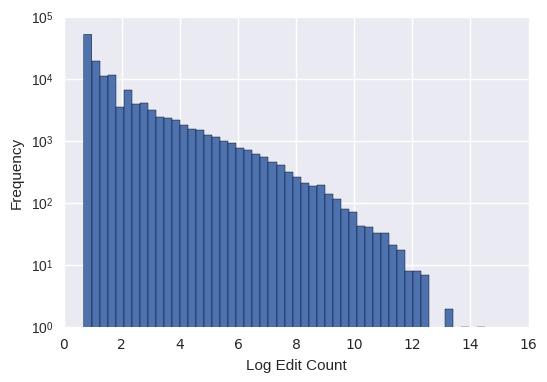

In [101]:
users_items_notools.hist(column='logEditCount',bins=50,log=True)
#plt.title('Volume of Edits')

plt.pyplot.xlabel('Log Edit Count');
plt.pyplot.ylabel('Frequency')
plt.pyplot.title('')
#plt.show()

In [54]:
users_items_notools['editCount'].describe()

count    1.395490e+05
mean     2.452043e+02
std      7.223193e+03
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      9.000000e+00
max      2.010637e+06
Name: editCount, dtype: float64

# Lifespan histogram 

In [55]:
users_items_notools.head()

,revContributor,editCount,lifespan,start,end,gone,logEditCount
0,1,1901,44.333333,2012-11-01 00:21:16,2016-06-23 14:46:51,0,7.550661
1,2,1049,41.700000,2012-10-29 17:41:05,2016-04-03 12:21:35,0,6.956545
2,3,340,39.900000,2013-03-21 23:43:18,2016-07-01 15:10:56,0,5.831882
3,4,266,19.866667,2012-10-31 01:35:44,2014-06-19 05:46:47,1,5.587249
4,7,1,0.000000,2014-04-28 01:03:37,2014-04-28 01:03:37,1,0.693147


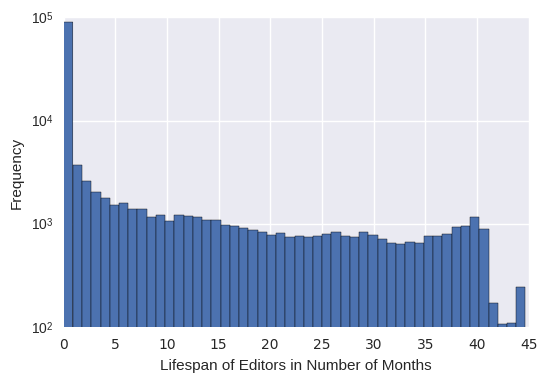

In [105]:
users_items_notools.hist(column='lifespan',bins=50,log=True)
plt.pyplot.xlabel('Lifespan of Editors in Number of Months')
plt.pyplot.ylabel('Frequency')
plt.pyplot.title('')
#plt.title('Lifespan')

In [57]:
users_items_notools['lifespan'].describe()

count    139549.000000
mean          6.165338
std          11.204758
min           0.000000
25%           0.000000
50%           0.000000
75%           7.100000
max          44.700000
Name: lifespan, dtype: float64

In [58]:
users_items_notools_gone = users_items_notools.loc[users_items_notools['gone'] == 1]

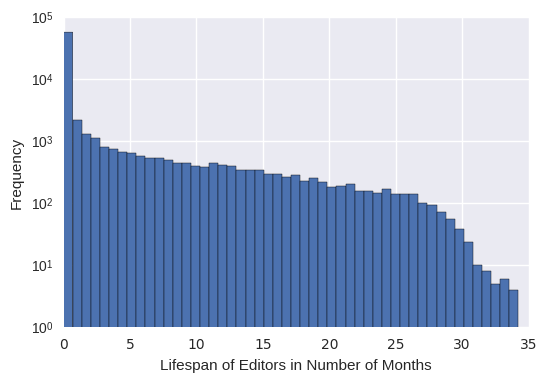

In [106]:
users_items_notools_gone.hist(column='lifespan',bins=50,log=True)
plt.pyplot.xlabel('Lifespan of Editors in Number of Months')
plt.pyplot.ylabel('Frequency')
plt.pyplot.title('')
#plt.title('Lifespan')

In [60]:
users_items_notools_gone['lifespan'].describe()

count    75285.000000
mean         2.156956
std          5.319427
min          0.000000
25%          0.000000
50%          0.000000
75%          0.433333
max         34.233333
Name: lifespan, dtype: float64

# Users per items

In [68]:
def countdistincteditors(group):
    return group['revContributor'].nunique()

In [76]:
data_items_notools_gitem = notooledits_items.groupby(by='revPage')
editors = data_items_notools_gitem.apply(countdistincteditors)

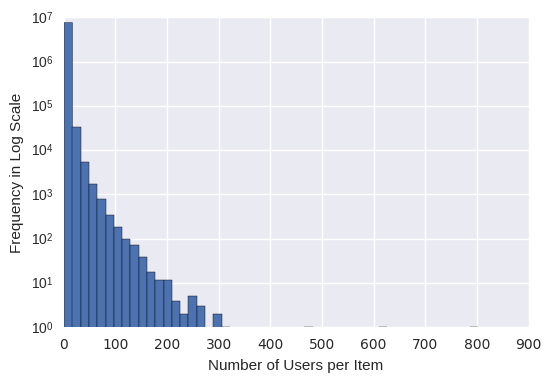

In [109]:
editors.hist(bins=50,log=True)
#plt.title('Users per Item')
plt.pyplot.xlabel('Number of Users per Item');
plt.pyplot.ylabel('Frequency in Log Scale')
plt.pyplot.title('')

In [78]:
editors.describe()

count    7.633131e+06
mean     2.159856e+00
std      3.088948e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      8.030000e+02
dtype: float64

# User base

In [ ]:
# Start end and drop out

In [79]:
def getyear(t):
    timestamp = pd.to_datetime(t)
    return timestamp.year

In [80]:
# User start and End
users_items_notools['startyear'] = users_items_notools['start'].apply(lambda x: getyear(x))
users_items_notools['endyear'] = users_items_notools['end'].apply(lambda x: getyear(x))

users_items_notools.head()

,revContributor,editCount,lifespan,start,end,gone,logEditCount,startyear,endyear
0,1,1901,44.333333,2012-11-01 00:21:16,2016-06-23 14:46:51,0,7.550661,2012,2016
1,2,1049,41.700000,2012-10-29 17:41:05,2016-04-03 12:21:35,0,6.956545,2012,2016
2,3,340,39.900000,2013-03-21 23:43:18,2016-07-01 15:10:56,0,5.831882,2013,2016
3,4,266,19.866667,2012-10-31 01:35:44,2014-06-19 05:46:47,1,5.587249,2012,2014
4,7,1,0.000000,2014-04-28 01:03:37,2014-04-28 01:03:37,1,0.693147,2014,2014


In [81]:
ustart = users_items_notools.groupby(by='startyear')
started = ustart.size()
print(started)

startyear
2012      832
2013    35322
2014    37932
2015    42112
2016    23351
dtype: int64


In [82]:
uend= users_items_notools.groupby(by='endyear')
ended = uend.size()
print(ended)


endyear
2012       75
2013    16935
2014    30566
2015    43679
2016    48294
dtype: int64


2012       75
2013    16868
2014    26533
2015    34420
2016    23351
dtype: int64
      started  stopped  started_and_stopped
2012      832       75                   75
2013    35322    16935                16868
2014    37932    30566                26533
2015    42112    43679                34420
2016    23351    48294                23351


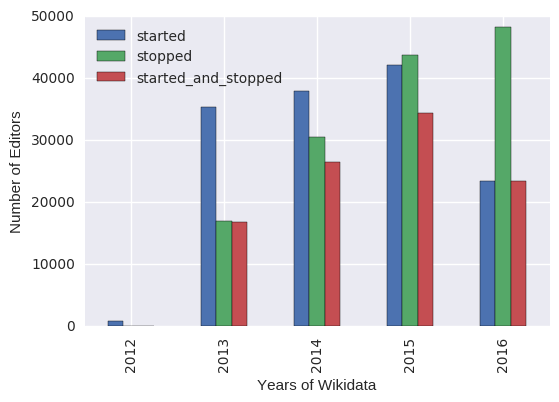

In [96]:
# Manual dirty quick calculation
use2012 = users_items_notools.loc[(users_items_notools['startyear']==2012) & (users_items_notools['endyear']==2012)]
use2012c = len(use2012)

use2013 = users_items_notools.loc[(users_items_notools['startyear']==2013) & (users_items_notools['endyear']==2013)]
use2013c = len(use2013)

use2014 = users_items_notools.loc[(users_items_notools['startyear']==2014) & (users_items_notools['endyear']==2014)]
use2014c = len(use2014)

use2015 = users_items_notools.loc[(users_items_notools['startyear']==2015) & (users_items_notools['endyear']==2015)]
use2015c = len(use2015)

use2016 = users_items_notools.loc[(users_items_notools['startyear']==2016) & (users_items_notools['endyear']==2016)]
use2016c = len(use2016)

ustartandend = pd.Series([use2012c,use2013c,use2014c,use2015c,use2016c])
ustartandend.index=[2012,2013,2014,2015,2016]
print(ustartandend)


data_startend = pd.concat([started,ended,ustartandend],axis=1)
data_startend.columns=['started','stopped','started_and_stopped']
print(data_startend.head())

data_startend.plot.bar()
plt.xlabel('Years of Wikidata')
plt.ylabel('Number of Editors')
#plt.title('Change in User Base')

In [84]:
ploteditsperstartyear = users_items_notools[['revContributor','editCount','startyear']]
ploteditsperstartyear.head()

,revContributor,editCount,startyear
0,1,1901,2012
1,2,1049,2012
2,3,340,2013
3,4,266,2012
4,7,1,2014


/home/alex/.virtualenvs/markov/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


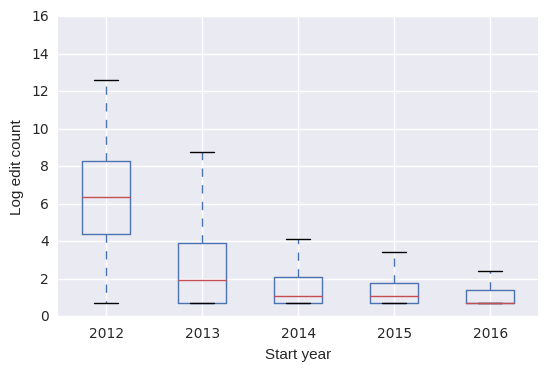

In [110]:
ploteditsperstartyear['logEditCount'] = ploteditsperstartyear['editCount'].apply(lambda x: np.log(1+x))
ploteditsperstartyear.boxplot(column='logEditCount',by='startyear')
plt.pyplot.xlabel('Start year')
plt.pyplot.ylabel('Log edit count')
plt.pyplot.title('')
plt.pyplot.suptitle('')

In [86]:
gone = users_items.loc[users_items['gone']==1]

print(len(gone))
print(len(users_items_notools))

77698
139549


In [87]:
75285 / 139549

0.5394879218052441